### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2018 ###

# Contact Mechanics Optimization #

#### Zhuohan Li (zli627@wisc.edu) and Dongzheng Chen (dchen255@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
2. [Mathematical Model](#2.-Mathematical-model)
  1. [Variables, constaints and object function](#2.A.-Variables,-constaints-and-object-function)
  2. [Logical constaint and an MIQP model](#2.B.-Logical-constaint-and-an-MIQP-model)
  3. [Non-convex constaint and a continuous but non-convex model](#2.C.-Non-convex-constaint-and-a-continuous-but-non-convex-model)
  4. [Regularization and a continuous QP](#2.D.-Regularization-and-a-continuous-QP)
3. [Solution](#3.-Solution)
  1. [Functions](#3.A.-Functions)
  2. [Single asperity contact](#3.B.-Single-Asperity-Contact)
  3. [Randomly rough contact](#3.C.-Randomly-Rough-Contact)
4. [Results and Discussion](#4.-Results-and-discussion)
  1. [Regularization parameter](#4.A.-Regularization-parameter)
  2. [Performance comparison: Mosek, Gurobi, and Ipopt](#4.B.-Performance-comparison:-Mosek,-Gurobi,-and-Ipopt)
5. [Conclusion](#5.-Conclusion)
6. [Reference](#6.-Reference)

## 1. Introduction ##

Contact mechanics studies mechanical behaviors of solid interfaces at given applied load or surface separation. There are already well-established theories$^1$ (e.g., Hertzian contact theory$^2$) for single asperity contact mechanics problem, where the area—load relationship of the elastic contact between two spheres or a sphere and a flat surface can be solved exact analytically. However, most of the natural and industrial surfaces has roughness of length scale spans many orders of magnitude$^3$, i.e., from micro- to macro-scale. It means that the real contact area is also orders of magnitude smaller than nominal contact area, which can significantly affect the interfacial phenomena, such as friction, wear, adhesion, electrical contact resistance, and thermal contact resistance. Therefore, the analysis of local contact area/pressure distribution and contact morphology are extremely important.

Several analytical models for rough contacts have been developed so far. The first and the simplest one is the load bearing area model $^4$, where real contact is estimated by the geometrical overlap of two undeformed rough surface. The contact pressure is assumed to equal the material hardness throughout the real area of contact, while the surface displacements at non-contact points are neglected. There is also the multi asperity model$^5$ (e.g., Greenwood-Williamson model$^6$), where surface roughness is approximated by the infinite number of non-interacting single asperities with statistically distributed heights (and curvatures). Here, each asperity is treated the same as single asperity contact.

However, both of those approaches have serious deficiencies: they ignore the long-range elastic interactions between microcontacts. Neglecting these kind of long-range interaction can lead to inaccurate description of rough contacts. This problem becomes more significant as normal pressure increases, where there are more microcontacts in contact and surface deflection produced by neighbor microcontacts cannot be ignored.

In order to incorporate this kind of long-range elastic interactions, it is necessary to solve contact mechanics problem numerically. Here, we will implement the Boundary Element Method (BEM)$^{7–9}$ for frictionless elastic contact as a quadratic problem (QP), where the total complementary energy of contact is minimized under given normal pressure or surface separation. The long-range elastic interactions are included by introducing influence matrix$^{7,9}$ (detailed explanation will be given in the following section), which determines to what extent the surface deflection at a given site are affected by the pressures at neighbor sites. This model can be applied to arbitrary surface topography. We will first apply our model to single asperity contact to compare with the exact analytical solution. Then, we will use our model to solve the contact mechanics optimization problem for randomly rough fractal surface with various surface roughness$^{10}$. 

## 2. Mathematical model ##

### 2.A. Variables, constaints and object function

We assume that contact surface of two solids is the 2-dimension surface $S$.
Therefore, all the mechanical quantities which are functions of position can be written as function of coordinates $(x,y)$.
We assume that one of solids has a perfectly flat elastic surface, while the other has a rigid rough surface. We use the height of each position on the rough solid surface $h(x,y)$ to describe the surface topography. The long-range elastic interaction is introduced by the influence matrix, or Boussinesq equation kernel matrix, $\boldsymbol{K}$. This matrix determines how pressures at neighbors affect the local surface deflection.

It is difficult to use computer to optimize a functional instead of a function.
We discretize the surface $S$ into $N$ pixels using a square mesh, and use one index $i$ to label the pixels
($i = 1,2,\dots, N$).
After the discretization, all functions of position can be written as vectors. The $i$-th element of the vector means the value of the mechanical quantity at pixel $i$.

The table below shows the mechanical quantities that will be used in this model.
Bolded captical letters correspond matrices; bolded lower case letters for vectors; unbolded letters for scalars.

|Mechanical quantity|Coutinuum case|Discretized case|Matrix notation|
|-|-|-|-|
|Pressure|$p(x,y)≥0$|$p_i≥0$|$\boldsymbol{p}≥0$|
|Averaged pressure|$p_0=\frac1S\iint\limits_Sp(x,y)\mathrm{d}x\mathrm{d}y$|$p_0=\frac1N\sum\limits_ip_i$|$p_0=\mathrm{mean}(\boldsymbol{p})$|
|Boussinesq equation kernel (given)|$K(x-x',y-y')$|$K_{ij}$|$\boldsymbol{K}$|
|Deflection|$u(x,y)=\iint\limits_SK(x-x',y-y')p(x',y')\mathrm{d}x'\mathrm{d}y'$|$u_i=\sum\limits_jK_{ij}p_j$|$\boldsymbol{u}=\boldsymbol{K}\boldsymbol{p}$|
|Energy|$E=\frac12\iint\limits_Su(x,y)p(x,y)\mathrm{d}x\mathrm{d}y$|$E=\frac12\sum\limits_ip_iu_i$|$E=\frac12\boldsymbol{p}^{\mathrm{T}}\boldsymbol{u}$|
|Surface separation|$\alpha$|$\alpha$|$\alpha$|
|Surface topography (given)|$h(x,y)$|$h_i$|$\boldsymbol{h}$|
|Gap between two solids|$g(x,y)=\alpha-h(x,y)+u(x,y)≥0$|$g_i=\alpha-h_i+u_i≥0$|$\boldsymbol{g}=\alpha-\boldsymbol{h}+\boldsymbol{u}≥0$|

Physics requires that the Boussinesq equation kernel matrix be positive semidefinite $\boldsymbol{K}\succeq0$.

The mechanical system is in equilibrium when the energy $E$ is minimized. The mechanical problem can be written as the following optimalization program:

$$
\begin{aligned}
\underset{\text{variables}}{\text{minimize}}\qquad& E \\
\text{subject to:}\qquad& \text{constraints}\\
\end{aligned}
$$

### 2.B. Logical constaint and an MIQP model

Hertz-Signorini-Moreau contact condition requires that the pressure at one position $p(x,y)$ is nonzero only where two solids are touching, that is

|Coutinuum case|Discretized case|
|-|-|
|$p(x,y)>0\Rightarrow g(x,y)=0\quad\forall(x,y)$|$p_i>0\Rightarrow g_i=0\quad\forall i$|

A general way to describe such a logical constaint is introduce extra binary variables $z_i$:
$p_i>0\Rightarrow z=1\Rightarrow g_i=\alpha-h_i+\sum\limits_jK_{ij}p_j=0$, $\forall i$. Using big $M$ method

|Logical constraints|Equivalent propositions|Component notation|Matrix notation|
|-|-|-|-|
|$p_i>0\Rightarrow z_i=1$|$z_i=0\Rightarrow p_i≤0$|$p_i≤M_pz_i$|$\boldsymbol{p}≤M_p\boldsymbol{z}$|
|$z_i=1\Rightarrow g_i=0$|$z_i=1\Rightarrow g_i≤0$|$g_i≤M_g(1-z_i)$|$\boldsymbol{g}≤M_g\left(1-\boldsymbol{z}\right)$|

There are two common cases in the mechanical problem.
The first one is that the averaged pressure $p_0$ is given. 
Using the relationship between the mechanical quantities listed above, we can eliminate $\boldsymbol{u}$ and $\boldsymbol{g}$. The optimization problem can be written as
$$
\begin{aligned}
\min\limits_{\boldsymbol{p}\in\mathbb{R}^N,\,\alpha,\,\boldsymbol{z}\in\{0,1\}^N}\qquad& \frac12\boldsymbol{p}^{\mathrm{T}}\boldsymbol{K}\boldsymbol{p} \\
\text{subject to:}\qquad
&p_0=\mathrm{mean}(\boldsymbol{p})\\
&0≤\boldsymbol{p}≤M_p\boldsymbol{z}\\
&0≤\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}≤M_g\left(1-\boldsymbol{z}\right)\\
\end{aligned}
$$

In the other case when surface separation $\alpha$ is given:
$$
\begin{aligned}
\min\limits_{\boldsymbol{p}\in\mathbb{R}^N,\,\boldsymbol{z}\in\{0,1\}^N}\qquad& \frac12\boldsymbol{p}^{\mathrm{T}}\boldsymbol{K}\boldsymbol{p} \\
\text{subject to:}\qquad
&0≤\boldsymbol{p}≤M_p\boldsymbol{z}\\
&0≤\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}≤M_g\left(1-\boldsymbol{z}\right)\\
\end{aligned}
$$

Since $\boldsymbol{K}\succeq0$, the programs above are mixed-integer quadratic programs (MIQP).

### 2.C. Non-convex constaint and a continuous but non-convex model

An MIQP is usually not easy to solve, and we need to determine the values of $M$'s for the big $M$ method.
To simplify the program, the first step we would like to do is to use another way to describe the logical constaint and get rid of the integer variables.

Considering that $p(x,y)≥0$ and $g(x,y)≥0$ always hold, the constaint above is equivalent with

|Coutinuum case|Discretized case|
|-|-|
|$p(x,y)=0\text{ or }g(x,y)=0\quad\forall(x,y)$|$p_i=0\text{ or }g_i=0\quad\forall i$|

Therefore we can convert the logical constraint to an algebraic constaint:

|Coutinuum case|Discretized case|Matrix notation|
|-|-|-|
|$\iint\limits_Sp(x,y)g(x,y)\mathrm{d}x\mathrm{d}y=0$|$\sum\limits_ip_ig_i=0$|$\boldsymbol{p}^{\mathrm{T}}\boldsymbol{g}=0$|

Now we can get rid of the integer variables. In the case when the averaged pressure $p_0$ is given,
$$
\begin{aligned}
\min\limits_{\boldsymbol{p}≥0,\,\alpha}\qquad& \frac12\boldsymbol{p}^{\mathrm{T}}\boldsymbol{K}\boldsymbol{p} \\
\text{subject to:}\qquad
&p_0=\mathrm{mean}(\boldsymbol{p})\\
&\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}≥0\\
&\boldsymbol{p}^{\mathrm{T}}\left(\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}\right)=0\\
\end{aligned}
$$

In the case when surface separation $\alpha$ is given:
$$
\begin{aligned}
\min\limits_{\boldsymbol{p}≥0}\qquad& \frac12\boldsymbol{p}^{\mathrm{T}}\boldsymbol{K}\boldsymbol{p} \\
\text{subject to:}\qquad
&\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}≥0\\
&\boldsymbol{p}^{\mathrm{T}}\left(\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}\right)=0\\
\end{aligned}
$$

Notice that Hertz-Signorini-Moreau contact condition $\boldsymbol{p}^{\mathrm{T}}\left(\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}\right)=0$ is a nonlinear equality constaint.
The solution set of this equation of $\boldsymbol{p}$ is the surface of an ellipsoid, which is non-convex.
Therefore, the programs above are continuous but non-convex programs.

### 2.D. Regularization and a continuous QP

A non-convex program is even more difficult to solve than an MIQP.
In order to solve the problem more efficiently,
we put the nonlinear equality into the object function as a regularization to make the program convex.
For example, in the case when the averaged pressure $p_0$ is given,
$$
\begin{aligned}
\min\limits_{\boldsymbol{p}≥0,\,\alpha}\qquad& \frac12\boldsymbol{p}^{\mathrm{T}}\boldsymbol{K}\boldsymbol{p}+\lambda\boldsymbol{p}^{\mathrm{T}}\left(\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}\right) \\
\text{subject to:}\qquad
&p_0=\mathrm{mean}(\boldsymbol{p})\\
&\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}≥0\\
\end{aligned}
$$
where $\lambda$ is the regularization parameter. 

The problem above is a contiuous quadratic program (QP), much easier to solve than an MIQP or a continuous non-convex program.

A large $\lambda$ will lead to a small $\boldsymbol{p}^{\mathrm{T}}\left(\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}\right)$ at optimal $\boldsymbol{p}=\boldsymbol{p}^\ast$.
The Hertz-Signorini-Moreau contact condition can approximately be satisfied.
The optimal value of this QP can be close to the solution of the original MIQP.

In the other case when surface separation $\alpha$ is given, we can get a QP in a similar way,
$$
\begin{aligned}
\min\limits_{\boldsymbol{p}≥0}\qquad& \frac12\boldsymbol{p}^{\mathrm{T}}\boldsymbol{K}\boldsymbol{p}+\lambda\boldsymbol{p}^{\mathrm{T}}\left(\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}\right) \\
\text{subject to:}\qquad
&\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}≥0\\
\end{aligned}
$$

## 3. Solution ##

Here, we code with Julia + JuMP and different solvers to solve the QPs.

When the averaged pressure $p_0$ is given,
$$
\begin{aligned}
\min\limits_{\boldsymbol{p}≥0,\,\alpha}\qquad& \frac12\boldsymbol{p}^{\mathrm{T}}\boldsymbol{K}\boldsymbol{p}+\lambda\boldsymbol{p}^{\mathrm{T}}\left(\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}\right) \\
\text{subject to:}\qquad
&p_0=\mathrm{mean}(\boldsymbol{p})\\
&\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}≥0\\
\end{aligned}
$$

When surface separation $\alpha$ is given,
$$
\begin{aligned}
\min\limits_{\boldsymbol{p}≥0}\qquad& \frac12\boldsymbol{p}^{\mathrm{T}}\boldsymbol{K}\boldsymbol{p}+\lambda\boldsymbol{p}^{\mathrm{T}}\left(\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}\right) \\
\text{subject to:}\qquad
&\alpha-\boldsymbol{h}+\boldsymbol{K}\boldsymbol{p}≥0\\
\end{aligned}
$$

where the regularization parameter $\lambda$ should be large enough to get an approximate solution.

### 3.A. Functions

Those functions listed below will be used in the following sections (from 3.B.).

(1) Generate single asperity surface

In [1]:
function single_asperity(L, R, pixelwidth, lengunit, pressunit)
    surface = zeros(L,L)
    c = (L+1)/2.
    for i in 1:L
        for j in 1:L
            if (i - c)^2 + (j - c)^2 > R^2
                surface[i,j] = 0
            else
                surface[i,j] = sqrt(R^2 - ((i - c)^2 + (j - c)^2))
            end 
        end
    end
   return surface 
end

single_asperity (generic function with 1 method)

(2) Generate randomly rough fractal surface

In [2]:
function phase(L)
    #random phase matrix with size L*L
    phy = zeros(L, L)

    for i in 0:Int64(round(L/2))
        for j in 0:Int64(round(L/2))
            if i == 0 && j == 0
                continue
            else
                randnum = -pi+2*pi*rand(1)
                phy[i+1,j+1] = randnum[1]
                if i == 0
                        phy[1,L-j+1] = -phy[i+1,j+1]
                elseif j == 0
                    phy[L-i+1,1] = -phy[i+1,j+1]
                else 
                    phy[L-i+1,L-j+1] = -phy[i+1,j+1]
                    randnum = -pi+2*pi*rand(1)
                    phy[i+1,L-j+1] = randnum[1]
                    phy[L-i+1,j+1] = -phy[i+1,L-j+1]
                end
            end
        end
    end
    
    return phy
end

function pol2cart(theta, rho)
    #transform polar coordinate to Cartesian
    (a, b) = size(theta)
    X = zeros(a,b)
    Y = zeros(a,b)
    for i in 1:a
        for j in 1:b
            X[i,j] = rho[i,j] * cos(theta[i,j])
            Y[i,j] = rho[i,j] * sin(theta[i,j])
        end
    end
    return (X,Y)
end

# This is the main function
function fourier_filtering(H, L, rolloff, magnification, RMSslope, pixelwidth)

    # random phase matrix phy
    phy = phase(L);
    
    if (L < rolloff*magnification*2)
        println("Magnification or rolloff is too large. Please use 
            smaller magnification or rolloff")
        return
    end

    qL=2*pi/(L*pixelwidth) #minimum wavevector
    q0=rolloff*qL #roll-off wavevector
    q1=magnification*q0 #maximum wavevector
    
    alfa = -2+(1-H)*(1-(1/rolloff)^4)
    C0=RMSslope^2/pi*(2-2*H)/(2*q1^(2-2*H)+alfa*q0^(2-2*H))

    #power spectrum
    C = zeros(L,L)
    for i = 0:Int64(round(L/2))
        for j = 0:Int64(round(L/2))
            if i == 0 && j == 0
                continue
            end
            #current wavevector
            Q = qL*sqrt(i^2+j^2) 
            if Q < q0 || abs(Q-q0)<1e-4
                #current wavevector < roll-off wavevector
                C[i+1,j+1] = q0^(-2-2*H)
                if i == 0
                    C[1,L-j+1] = C[i+1,j+1]
                elseif j == 0
                    C[L-i+1,1] = C[i+1,j+1]
                else 
                    C[L-i+1,L-j+1] = C[i+1,j+1]
                    C[i+1,L-j+1] = C[i+1,j+1]
                    C[L-i+1,j+1] = C[i+1,L-j+1]
                end
            elseif Q < q1 || abs(Q-q1)<1e-8  
                # current wavevector < maximum wavevector
                C[i+1,j+1]=Q^(-2-2*H)
                if i == 0
                     C[1,L-j+1] = C[i+1,j+1]
                elseif j == 0
                     C[L-i+1,1] = C[i+1,j+1]
                else 
                    C[L-i+1,L-j+1] = C[i+1,j+1]
                    C[i+1,L-j+1] = C[i+1,j+1]
                    C[L-i+1,j+1] = C[i+1,L-j+1]        
                end
            end
        end
    end
    C[Int64(round(L/2))+1,Int64(round(L/2))+1] = 0.0
    C[1,Int64(round(L/2))+1] = 0.0
    C[Int64(round(L/2))+1,1] = 0.0
    B=zeros(L, L)
    C = C.*C0
    B = 2*pi/(L*pixelwidth)*sqrt.(C)
    (X,Y) = pol2cart(phy,B);
    Hm = L*L*complex.(X,Y);
    surface = ifft(Hm); #2 dimensional inverse FFT.
    
    return real(surface)
end

fourier_filtering (generic function with 1 method)

(3) Calculate Boussinesq equation kernel $K$.

In [9]:
function Boussinesq(L, pixelwidth, Eeff, option)
    K = zeros(L*L,L*L)
    if option == "periodic"
        for i = 1:L
            for j = 1:L
                for k = 1:L
                    for l = 1:L
                        if i == k && j == l
                            K[(i-1)*L+j, (k-1)*L+l] = 2*log(3+2*sqrt(2))*pixelwidth
                        else
                            K[(i-1)*L+j, (k-1)*L+l] = pixelwidth /
                            sqrt(min((i-k)^2, (i-k+L)^2, (i-k-L)^2) + 
                                min((j-l)^2, (j-l+L)^2, (j-l-L)^2))
                        end
                    end
                end
            end
        end
    elseif option == "non-periodic"
        for i = 1:L
            for j = 1:L
                for k = 1:L
                    for l = 1:L
                        if i == k && j == l
                            K[(i-1)*L+j, (k-1)*L+l] = 2*log(3+2*sqrt(2))*pixelwidth
                        else
                            K[(i-1)*L+j, (k-1)*L+l] = pixelwidth / norm([i-k, j-l])
                        end
                    end
                end
            end
        end
    end
    return K/(Eeff * pi)
end

Boussinesq (generic function with 1 method)

(4) Plot for 2D or 3D 

In [57]:
using PyPlot
function plotmaps(matrix, dimension, lengunit, pressunit, option)

    if (dimension == "2D")
        fig = figure(figsize=(4,4))
        ax = gca()
        X = 0:L;
        Y = 0:L;
        X = X.*pixelwidth;
        Y = Y.*pixelwidth;
        pcolormesh(X, Y, matrix, cmap = "jet")
        cb = colorbar(shrink = 0.8, aspect=10)
        xlabel("x ($lengunit)")
        ylabel("y ($lengunit)")
        xlim([0, L*pixelwidth])
        ylim([0, L*pixelwidth])
        ax[:set_aspect](1)
        if option == "surface"
            title("2D topography map")
            cb[:set_label]("Height ($lengunit)")
        elseif option == "pressure"
            title("2D pressure map")
            cb[:set_label]("Pressure ($pressunit)")
        elseif option == "deflection"
            title("2D deflection map")
            cb[:set_label]("Deflection ($lengunit)")
        end
    elseif (dimension == "3D")
        fig = figure(figsize=(6.5,5))
        ax = fig[:gca](projection="3d")
        X = 1:L;
        Y = 1:L;
        X = X.*pixelwidth;
        Y = Y.*pixelwidth;
        println("OK")
        plot_surface(X, Y, matrix, cmap="jet", 
            rstride = 1, cstride = 1, linewidth=0, antialiased = false)
        println("OK")
        xlabel("x ($lengunit)")
        ylabel("y ($lengunit)")
        xlim([0, L*pixelwidth])
        ylim([0, L*pixelwidth])
        
        if option == "surface"
            title("3D topography plot")
            zlabel("Height ($lengunit)")
            ax[:auto_scale_xyz]([0, 1000], [0, 1000], [-10,10])
        elseif option == "pressure"
            title("3D pressure plot")
            zlabel("Pressure ($pressunit)")
        elseif option == "deflection"
            title("3D deflection plot")
            zlabel("Deflection ($lengunit)")
        end
    end

end


plotmaps (generic function with 1 method)

(5) Compare the simulation results and the theoretical calculation results in Hertzian contact.

In [58]:
using PyPlot
function Hertzian(popt, lengunit, pressunit, pixelwidth)
    F = sum(popt)*pixelwidth*pixelwidth
    a0 = sum(maximum(popt,1).>1e-2)/2*pixelwidth
    d = zeros(L,L)
    c = (L+1)/2.
    for i in 1:L
        for j in 1:L
            d[i,j] = norm([i-c,j-c])
        end
    end
    d = reshape(d*pixelwidth, L*L)
    pcal = reshape(popt, L*L)
    n = 120
    r = linspace(0,a0*1.2,n)
    pth = zeros(n)
    for i in 1:n
        if r[i] < a0
            pth[i] = sqrt(1-(r[i]/a0)^2)*3*F/2/pi/a0/a0
        end
    end
    fig = figure(figsize=(5,3))
    plot(d, pcal, "b.",r,pth,"g-")
    axis([0,1.2*a0,0,maximum([maximum(pcal),maximum(pth)])])
    title("Result comparison in pressure profile")
    xlabel("Distance from the tip center ($lengunit)")
    ylabel("Pressure ($pressunit)")
    legend(["Simulation", "Theory"], loc="lower left");
end

Hertzian (generic function with 1 method)

### 3.B. Single Asperity Contact

In this part, contact mechanics problems will be solved for single asperity contact. Two types of models (model 1: given normal pressure or model 2: given surface separation) are solved, which gives the local pressure distribution and surface deflection distribution. The optimization results of local pressure distribution are compared with available theoretical prediction for Hertzian contact.

#### Surface parameters

In [59]:
L = 30               # Mesh size
R = 14               # tip radius
pixelwidth = 1       # size of a pixel
lengunit = "nm";     # length unit
pressunit = "GPa";   # pressure unit

#### Generate the topography

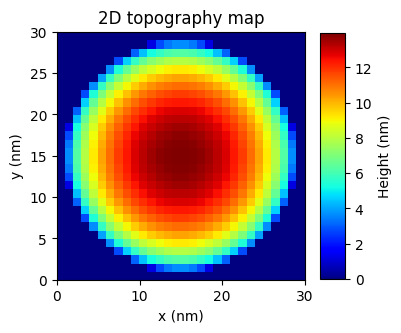

In [60]:
# generate the surface topography
single_asp_surface = single_asperity(L, R, pixelwidth, lengunit, pressunit)

# 2D
plotmaps(single_asp_surface, "2D", lengunit, pressunit,"surface");
# 3D
#plotmaps(single_asp_surface, "3D", lengunit, pressunit,"surface");

#### Model 1: averaged pressure $p_0$ is given

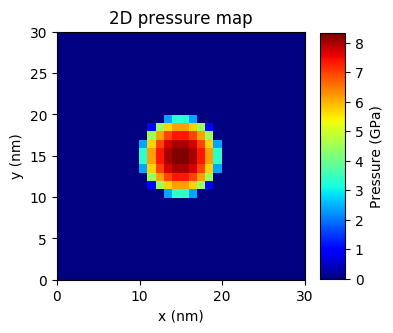

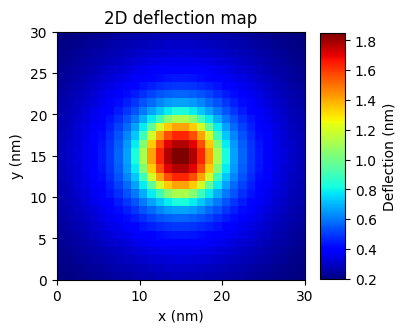

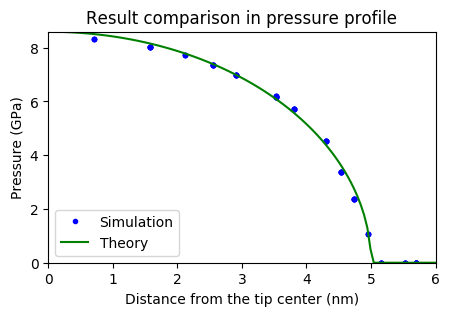

PyObject <matplotlib.legend.Legend object at 0x126bdb9e8>

In [12]:
# solid mechanical properties
Eeff = 35.3
K = Boussinesq(L, pixelwidth, Eeff, "non-periodic") 
 
# surface height
h = reshape(single_asp_surface, L*L)

# normal pressure
P0 = 0.5

# Regularization parameter
lambda = 100
 
using JuMP, PyPlot, Mosek
m = Model(solver = MosekSolver(LOG=0))
@variable(m, p[1:L*L] >= 0)     # local pressure
@variable(m, alpha)      # surface separation
 
@constraint(m, h - K*p .<= alpha)
@constraint(m, sum(p) == P0 * L * L)

@objective(m, Min, 0.5*p'*K*p + lambda*(p'*K*p + P0*L*L*alpha - vecdot(p,h)))

solve(m);
popt = reshape(getvalue(p),L,L)
uopt = reshape(K*getvalue(p),L,L)
# 2D
plotmaps(popt,"2D", lengunit, pressunit,"pressure")
plotmaps(uopt,"2D", lengunit, pressunit,"deflection")
# 3D
#plotmaps(popt,"3D", lengunit, pressunit,"pressure")
#plotmaps(uopt,"3D", lengunit, pressunit,"deflection")
Hertzian(popt, lengunit, pressunit, pixelwidth)

#### Model 2: surface separation $\alpha$ is given

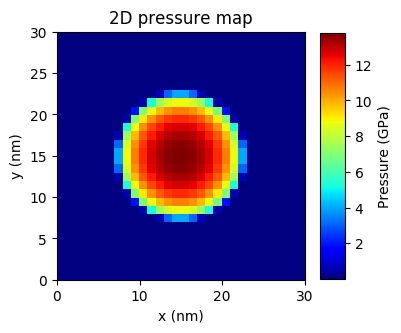

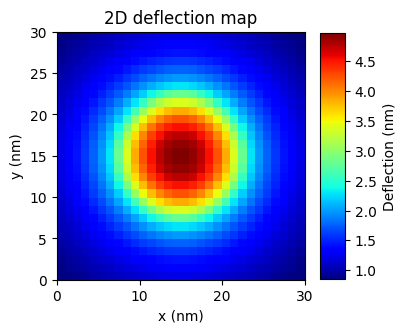

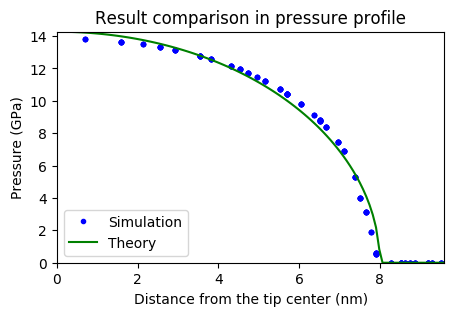

PyObject <matplotlib.legend.Legend object at 0x13d2484e0>

In [14]:
# solid mechanical properties
Eeff = 35.3
K = Boussinesq(L, pixelwidth, Eeff, "non-periodic")
 
# surface height
h = reshape(single_asp_surface, L*L)
 
# surface separation
alpha = 9

# Regularization parameter
lambda = 100
 
using JuMP, PyPlot, Mosek
m = Model(solver = MosekSolver(LOG=0))
@variable(m, p[1:L*L] >= 0)     # local pressure
 
@constraint(m, h - K*p .<= alpha)
 
@objective(m, Min, 0.5*p'*K*p + lambda*(p'*K*p + alpha*sum(p) - vecdot(p,h)))
 
solve(m);
popt = reshape(getvalue(p),L,L)
uopt = reshape(K*getvalue(p),L,L)
# 2D
plotmaps(popt,"2D", lengunit, pressunit,"pressure")
plotmaps(uopt,"2D", lengunit, pressunit,"deflection")
# 3D
#plotmaps(popt,"2D", lengunit, pressunit,"pressure")
#plotmaps(uopt,"2D", lengunit, pressunit,"deflection")
Hertzian(popt, lengunit, pressunit, pixelwidth)

As it can be seen, both models agrees quite well with the theory, indicating the success of building a contact mechanics optimization model.

### 3.C. Randomly Rough Contact
In this part, contact mechanics problems will be solved for randomly rough fractal surface. Again, two types of models (model 1: given normal pressure or model 2: given surface separation) are solved, which gives the local pressure distribution and surface deflection distribution

The real contact area can be defined as the area occupied by pixels with positive pressures. As it can be seen from the pressure distribution maps, the real contact area is only a small fraction of nominal contact area when surface roughness is considered.

#### Roughness parameters (inputs)

In [1]:
H = 0.8               # Hurst exponent, 0 < H < 1
L = 30                # Mesh size (> 2*rolloff*magnification)
rolloff = 2           # the ratio roll-off wavevector/minimum wavevector
magnification = 6     # the ratio maximum wavevector/minimum wavevector
RMSslope = 0.05        # root mean square of the surface slope
pixelwidth = 1        # size of a pixel
lengunit = "nm";      # length unit
pressunit = "GPa";    # pressure unit

#### Generate the topography

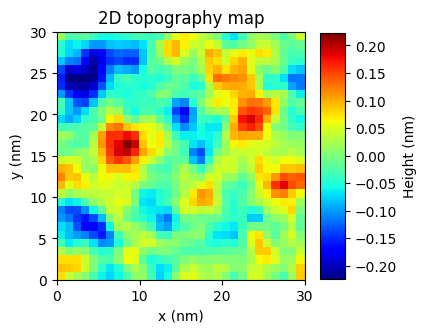

In [74]:
# generate the surface topography
rough_surface = fourier_filtering(H, L, rolloff, magnification, RMSslope, pixelwidth)

# 2D
plotmaps(rough_surface, "2D", lengunit, pressunit,"surface");
# 3D
#plotmaps(rough_surface, "3D", lengunit, pressunit,"surface");

#### Model 1: averaged pressure $p_0$ is given

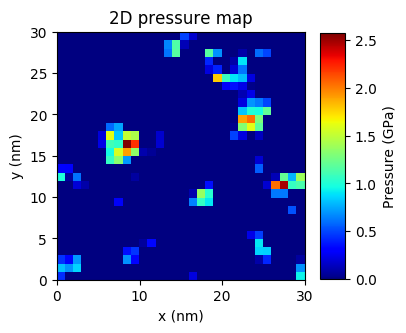

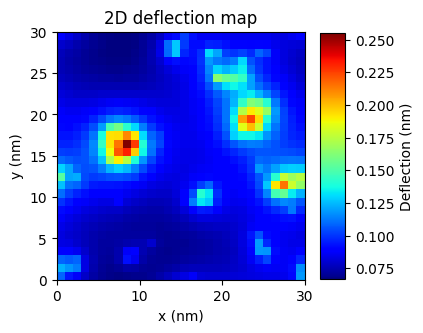

In [79]:
# solid mechanical properties
Eeff = 35.3
K = Boussinesq(L, pixelwidth, Eeff, "periodic") 
 
# surface height
h = reshape(rough_surface, L*L)
 
# normal pressure
P0 = 0.1

# Regularization parameter
lambda = 100

using JuMP, PyPlot, Mosek
m = Model(solver = MosekSolver(LOG=0))

@variable(m, p[1:L*L] >= 0)     # local pressure
@variable(m, alpha)      # surface separation
 
@constraint(m, h - K*p .<= alpha)
@constraint(m, sum(p) == P0 * L * L)
 
@objective(m, Min, 0.5*p'*K*p + lambda*(p'*K*p + P0*L*L*alpha - vecdot(p,h)))
 
solve(m);
popt = reshape(getvalue(p),L,L)
uopt = reshape(K*getvalue(p),L,L)
# 2D
plotmaps(popt,"2D", lengunit, pressunit,"pressure")
plotmaps(uopt,"2D", lengunit, pressunit,"deflection")
#3D
#plotmaps(popt,"3D", lengunit, pressunit,"pressure")
#plotmaps(uopt,"3D", lengunit, pressunit,"deflection")

#### Model 2: surface separation $\alpha$ is given

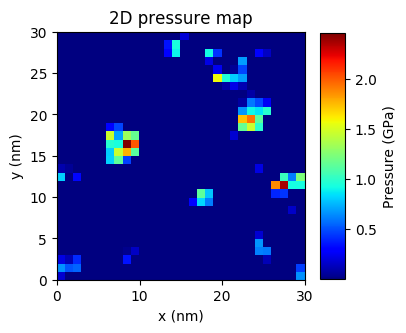

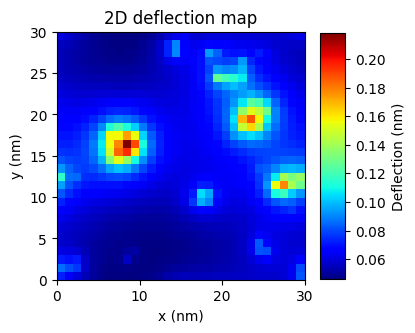

In [76]:
# solid mechanical properties
Eeff = 35.3
K = Boussinesq(L, pixelwidth, Eeff, "periodic")
 
# surface height
h = reshape(rough_surface, L*L)
 
# surface separation
alpha = 0.01   

# Regularization parameter
lambda = 100
 
using JuMP, PyPlot, Mosek
m = Model(solver = MosekSolver(LOG=0))
@variable(m, p[1:L*L] >= 0)     # local pressure
 
@constraint(m, h - K*p .<= alpha)
 
@objective(m, Min, 0.5*p'*K*p + lambda*(p'*K*p + alpha*sum(p) - vecdot(p,h)))
 
solve(m);
popt = reshape(getvalue(p),L,L)
uopt = reshape(K*getvalue(p),L,L)
# 2D
plotmaps(popt,"2D", lengunit, pressunit,"pressure")
plotmaps(uopt,"2D", lengunit, pressunit,"deflection")
# 3D
#plotmaps(popt,"3D", lengunit, pressunit,"pressure")
#plotmaps(uopt,"3D", lengunit, pressunit,"deflection")

## 4. Results and discussion ##
Now we are able to approximately solve the contact mechanics problem with the QPs.
Especially in the single asperity contact case, the optimal values are very close to the results from theoretical equations.

### 4.A. Regularization parameter

Regularization takes a key role in simplifying the program to a QP.
Theoretically, a larger regularization parameter leads to a result closer to the original MIQP.
On the other hand, a larger regularization parameter $\lambda$ may not suitable for floating number operations, and therefore may cause warnings and errors for solvers.

The figure below shows that as $\lambda$ becomes larger and larger, the results become closer and closer to the theoretical result. However, when $\lambda$ becomes too large, warnings will happen; if $\lambda$ continues to increase, it could be impossible for the solver to solve the QP.

In the case below, $\lambda = 100$ or $\lambda = 1000$ could be a good choice for the regularization parameter.

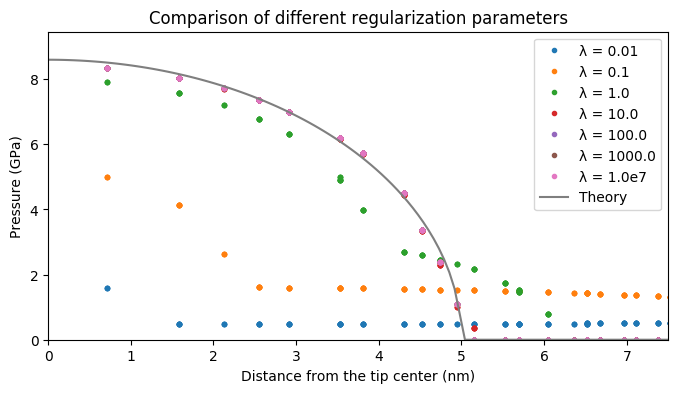

MOSEK warning 57: A large value of -1.0e+08 has been specified in cx for variable '' (163).
MOSEK warning 57: A large value of -1.0e+08 has been specified in cx for variable '' (164).
MOSEK warning 57: A large value of -1.0e+08 has been specified in cx for variable '' (165).
MOSEK warning 57: A large value of -1.0e+08 has been specified in cx for variable '' (166).
MOSEK warning 57: A large value of -1.0e+08 has been specified in cx for variable '' (190).
MOSEK warning 57: A large value of -1.1e+08 has been specified in cx for variable '' (191).
MOSEK warning 57: A large value of -1.1e+08 has been specified in cx for variable '' (192).
MOSEK warning 57: A large value of -1.1e+08 has been specified in cx for variable '' (193).
MOSEK warning 57: A large value of -1.1e+08 has been specified in cx for variable '' (194).
MOSEK warning 57: A large value of -1.1e+08 has been specified in cx for variable '' (195).


PyObject <matplotlib.legend.Legend object at 0x157eaf320>

In [36]:
L = 30               # Mesh size
R = 14               # tip radius
pixelwidth = 1       # size of a pixel
lengunit = "nm";     # length unit
pressunit = "GPa";   # pressure unit

# generate the surface topography
single_asp_surface = single_asperity(L, R, pixelwidth, lengunit, pressunit);

# solid mechanical properties
Eeff = 35.3
K = Boussinesq(L, pixelwidth, Eeff, "non-periodic") 
 
# surface height
h = reshape(single_asp_surface, L*L)

# normal pressure
P0 = 0.5

# Regularization parameter

lambda = [0.01,0.1,1,10,100,1000,1e7]

# Calculate the distance of the mesh
d = zeros(L,L)
c = (L+1)/2.
for i in 1:L
    for j in 1:L
        d[i,j] = norm([i-c,j-c])
    end
end
d = reshape(d*pixelwidth, L*L)

using JuMP, PyPlot, Mosek
fig, ax = subplots(figsize=(8,4))

yaxis = 0
for i in 1:length(lambda)
    thislambda = lambda[i]
    m = Model(solver = MosekSolver(LOG=0))
    @variable(m, p[1:L*L] >= 0)     # local pressure
    @variable(m, alpha)      # surface separation

    @constraint(m, h - K*p .<= alpha)
    @constraint(m, sum(p) == P0 * L * L)

    @objective(m, Min, 0.5*p'*K*p + lambda[i]*(p'*K*p + P0*L*L*alpha - vecdot(p,h)))

    status = solve(m);
    ax[:plot](d,getvalue(p),".", alpha=5, label="λ = $thislambda")
    yaxis = maximum([yaxis,maximum(getvalue(p))])
end

F = P0*L*L*pixelwidth*pixelwidth
a0 = sum(maximum(reshape(getvalue(p),L,L),1).>1e-2)/2*pixelwidth
n = 120
r = linspace(0,a0*1.5,n)
pth = zeros(n)
for i in 1:n
    if r[i] < a0
        pth[i] = sqrt(1-(r[i]/a0)^2)*3*F/2/pi/a0/a0
    end
end
ax[:plot](r,pth,"-", label="Theory")
axis([0,1.5*a0,0,1.1*maximum([yaxis,maximum(pth)])])
title("Comparison of different regularization parameters")
xlabel("Distance from the tip center ($lengunit)")
ylabel("Pressure ($pressunit)")
ax[:legend](loc="upper right")

### 4.B. Performance comparison: Mosek, Gurobi, and Ipopt

Optimization performance are compared between Mosek, Gurobi, and Ipopt for numbers of mesh sizes. The results shown below indicate that Mosek has better performance than Gurobi and Ipopt for this QP model.

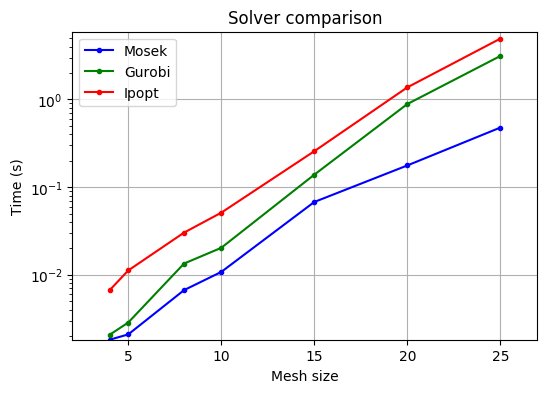

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [39]:
### given constant pressure

using JuMP, Mosek, Gurobi, Ipopt

## parameters
# System size (> 2*rolloff*magnification)
L_list = [4, 4, 5, 8, 10, 15, 20, 25]
# the ratio roll-off wavevector/minimum wavevector
rolloff_list = [1, 1, 1, 2, 2, 2, 2, 2]    
# the ratio maximum wavevector/minimum wavevector
magnification_list = [2, 2, 2, 2, 2, 3, 4, 6] 
H = 0.8               # Hurst exponent, 0 < H < 1
RMSslope = 0.2        # root mean square of the surface slope
pixelwidth = 1        # size of a pixel
lengunit = "nm";      # length unit
pressunit = "GPa";    # pressure unit

# solvers
solvername = ["Mosek", "Gurobi","Ipopt"]

solver_num = length(solvername)
surface_num = length(L_list)

# Regulation parameter
lambda = 100

TIME = zeros(solver_num, surface_num)
for i in 1:solver_num
    for j in 1:surface_num
        L = L_list[j]
        rolloff = rolloff_list[j] 
        magnification = magnification_list[j]
        
        # generate the surface topography
        rough_surface = fourier_filtering(H, L, rolloff, magnification, RMSslope, pixelwidth);

        # solid mechanical properties
        Eeff = 35.3
        K = Boussinesq(L, pixelwidth, Eeff, "periodic") 

        # surface height
        h = reshape(rough_surface, L*L)

        # normal pressure
        P0 = 0.05
        
        if solvername[i] == "Mosek"
            m = Model(solver = MosekSolver(LOG=0))
        elseif solvername[i] == "Gurobi"
            m = Model(solver = GurobiSolver(OutputFlag=0))
        elseif solvername[i] == "Ipopt"
            m = Model(solver = IpoptSolver(print_level=0))
        end
        @variable(m, p[1:L*L] >= 0)     # local pressure
        @variable(m, alpha)      # surface separation

        @constraint(m, h - K*p .<= alpha)
        @constraint(m, sum(p) == P0 * L * L)

        @objective(m, Min, 0.5*p'*K*p + lambda*(p'*K*p + P0*L*L*alpha - vecdot(p,h)))
        
        tic()
        status = solve(m)
        TIME[i,j] = toq()
    end
end

using PyPlot
fig = figure(figsize=(6,4))
semilogy(L_list[2:end], TIME[1,2:end], "b.-", label=solvername[1])
semilogy(L_list[2:end], TIME[2,2:end], "g.-", label=solvername[2])
semilogy(L_list[2:end], TIME[3,2:end], "r.-", label=solvername[3])
xlim([L_list[1]-2, L_list[surface_num]+2])
ylim([0, maximum(TIME)*1.2])
title("Solver comparison")
xlabel("Mesh size")
ylabel("Time (s)")
legend(loc = "upper left");
grid()

## 5. Conclusion ##

Contact mechanics problem is a non-convex program and difficult to solve.
In order to solve the program more efficiently,
we use a QP to get an approximate solution to the original non-convex program.
Calculation results show that the error due to such an approximation is negligible.

Our model for single asperity contact agrees quite well with theoretical predictions. We also built the model for randomly rough contacts with long-range elastic interactions, whose contact pressure/morpholgy cannot be predicted by a theory. Our model shows that the real contact area is only a fraction of nominal contact area if surface roughness is considered.

The current model is still computationally expesinve for the optimization problem with mesh size larger than ~30. Further simplification is needed for finer mesh grids, which will be a future work.


## 6. Reference ##
1.	Carpick, R. W., Ogletree, D. F. & Salmeron, M. A General Equation for Fitting Contact Area and Friction vs Load Measurements Robert. J. Colloid Interface Sci. 400, 395–400 (1999).
2.	Müser, M. H. On the Contact Area of Nominally Flat Hertzian Contacts. Tribol. Lett. 64, (2016).
3.	Persson, B. N. J., Albohr, O., Tartaglino, U., Volokitin,  a I. & Tosatti, E. On the nature of surface roughness with application to contact mechanics, sealing, rubber friction and adhesion. J. Phys. Condens. Matter 17, R1–R62 (2005).
4.	Pei, L., Hyun, S., Molinari, J.-F. & Robbins, M. O. Finite element modeling of elasto-plastic contact between rough surfaces. J. Mech. Phys. Solids 53, 2385–2409 (2005).
5.	Bhushan, B. Contact mechanics of rough surfaces in tribology: multiple asperity contact. Tribol. Lett. 4, 1–35 (1998).
6.	Greenwood, J. a. & Williamson, J. B. P. Contact of Nominally Flat Surfaces. Proc. R. Soc. A Math. Phys. Eng. Sci. 295, 300–319 (1966).
7.	Yastrebov, V. A., Anciaux, G. & Molinari, J.-F. On the accurate computation of the true contact-area in mechanical contact of random rough surfaces. Tribiology Int. 114, 161–171 (2016).
8.	Stanley, H. M. & Kato, T. An FFT-based method for rough surface contact. J. Tribol. 1, 2–6 (1997).
9.	Polonsky, I. A. & Keer, L. M. A numerical method for solving rough contact problems based on the multi-level multi-summation and conjugate gradient techniques. Wear 231, 206–219 (1999).
10.	Jacobs, T., Junge, T. & Pastewka, L. Quantitative characterization of surface topography using spectral analysis. Surf. Topogr. Metrol. Prop. 5, 13001 (2017).